# Libraries, figure parameters and custom functions

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ann
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams
#from gprofiler import gprofiler
import os
#import custom_functions as cf 
from sklearn.linear_model import LinearRegression

Add date.

In [3]:
from datetime import date

In [4]:
today = date.today().strftime("%y%m%d")

Add my color scheme.

In [5]:
colors2 = plt.cm.RdYlBu_r(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(0.7)
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

Set parameters for plots in scanpy

In [6]:
sc.settings.set_figure_params(dpi=80)

sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map='viridis', format='pdf', transparent=False,
                     ipython_format='png2x')

In [7]:
def cell_compo_table(adata, cluster, condition, xlabel='cell cluster',
                        ylabel='cell count', title=None, save=False):
    """
    """
    

    contingency_table = pd.crosstab(
        adata.obs[condition],
        adata.obs[cluster],
        margins = True
    )
    return(contingency_table)

def top_marker_as_xlsx(adata, key_rank_genes, key_groups, output_file):
    
    print(adata.uns[key_rank_genes].keys())
    dict_genes = adata.uns[key_rank_genes].copy()
    print(dict_genes['params'])
    del dict_genes['params']
    clusters = sorted(list(set(adata.obs[key_groups])))*len(dict_genes['scores'])
    for key, value in dict_genes.items():
        tmp_list = []
        for n in value:
            tmp_list = tmp_list + list(n)
        dict_genes[key] = tmp_list
    
    dict_genes['cluster'] = clusters

    dataframe = pd.DataFrame(dict_genes)
    dataframe.to_excel(output_file)
    return(dataframe)

# Load data

In [8]:
project_dir = '/lustre/groups/ml01/workspace/maren.buettner/Martinez_Liver_HPC/'

In [9]:
data_dir = project_dir + 'data/'
table_dir = project_dir + 'tables/'

In [10]:
adata_wt_young = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_young_cells_filtered_TPM_jul21_annotated.h5ad')
adata_wt_old = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_old_cells_filtered_TPM_jul21_annotated.h5ad')

In [11]:
adata_wt_young.var[['gene_name', 'mean_exp_TPM']].to_csv(table_dir + '220406_gene_mean_all.csv')

In [12]:
adata_young_HNF4 = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_young_HNF4-KO_filtered_TPM_jul21_annotated.h5ad')
adata_old_HNF4 = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_old_HNF4-KO_filtered_TPM_jul21_annotated.h5ad')
adata_young_CTCF = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_young_CTCF-KO_filtered_TPM_jul21_annotated.h5ad')
adata_old_CTCF = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_old_CTCF-KO_filtered_TPM_jul21_annotated.h5ad' )
adata_young_CEBPA = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_young_CEBPA-KO_filtered_TPM_jul21_annotated.h5ad')
adata_old_CEBPA = sc.read(data_dir + 'snRNAseq_mouse_hepatocytes_old_CEBPA-KO_filtered_TPM_jul21_annotated.h5ad')

We merge `adata_young` and `adata_old` in order to use the separately created cell type annotation.

In [13]:
adata_all = ann.concat([adata_wt_young, adata_wt_old, 
                        adata_young_HNF4, adata_old_HNF4,
                        adata_young_CTCF, adata_old_CTCF,
                        adata_young_CEBPA, adata_old_CEBPA,
                       ], index_unique=None)

In [14]:
adata_all.uns = adata_wt_young.uns
adata_all.varm = adata_wt_young.varm
adata_all.var['gene_name'] = adata_wt_young.var['gene_name']

Add covariate combining age and ploidy.

In [15]:
age_ploidy = [adata_all.obs['age_grouped'][idx] + ' ' + adata_all.obs['ploidy'][idx] for idx in range(adata_all.n_obs)]

In [16]:
adata_all.obs['age_ploidy'] = pd.Categorical(age_ploidy, categories=['young 2n', 'young 4n', 'old 2n', 'old 4n'])

Add strain information to the age and ploidy covariate.

In [17]:
strain_age_ploidy = [adata_all.obs['strain'][idx] + ' ' + 
                     adata_all.obs['age_grouped'][idx] + ' ' + 
                     adata_all.obs['ploidy'][idx] for idx in range(adata_all.n_obs)]

In [18]:
adata_all.obs['strain_age_ploidy'] = pd.Categorical(strain_age_ploidy, 
                                categories=['C57Bl6/J young 2n', 'C57Bl6/J young 4n', 
                                            'C57Bl6/J old 2n', 'C57Bl6/J old 4n',
                                            'HNF4 KO young 2n', 'HNF4 KO young 4n', 
                                            'HNF4 KO old 2n', 'HNF4 KO old 4n',
                                            'CEBPA KO young 2n', 'CEBPA KO young 4n', 
                                            'CEBPA KO old 2n', 'CEBPA KO old 4n',
                                            'CTCF KO young 2n', 'CTCF KO young 4n', 
                                            'CTCF KO old 2n', 'CTCF KO old 4n'
                                           ])

Add strain and age info as covariate.

In [19]:
strain_age = [adata_all.obs['strain'][idx] + ' ' + 
              adata_all.obs['age_grouped'][idx] for idx in range(adata_all.n_obs)]

In [20]:
adata_all.obs['strain_age'] = pd.Categorical(strain_age, 
                                categories=['C57Bl6/J young', 
                                            'C57Bl6/J old', 
                                            'HNF4 KO young', 
                                            'HNF4 KO old',
                                            'CEBPA KO young',
                                            'CEBPA KO old',
                                            'CTCF KO young',
                                            'CTCF KO old', 
                                           ])

Edit the raw object to use the gene symbols for plotting (e.g. in `stacked_violin` plot).

In [21]:
adata_all.raw.var['gene_name'] = adata_wt_young.var['gene_name']

Select hepatocytes.

In [22]:
adata_hep = adata_all[adata_all.obs['cell_type1']=='Hepatocytes'].copy()

In [23]:
adata_hep

AnnData object with n_obs × n_vars = 3969 × 30520
    obs: 'batch', 'exp.', 'libraryID', 'experiment', 'strain', 'age', 'sex', 'ploidy', 'ERCC.dilution', 'column', 'row', 'percentERCC', 'n_counts', 'age_grouped', 'n_counts_raw', 'n_counts_transcripts', 'n_counts_ERCC', 'n_genes', 'high_ERCC', 'low_ERCC', 'low_genes', 'high_genes', 'low_counts', 'high_counts', 'ERCC_size_factor', 'n_counts_TPM', 'RPK_factor', 'n_counts_TPM_norm', 'mean_transcript_count_TPM', 'cyclone_phases', 'score_G1', 'score_S', 'score_G2M', 'leiden_r1', 'leiden_r02', 'low_res_ct', 'clusters', 'score_Natural killer', 'score_Lymphocyte', 'score_Hepatoblast', 'score_Endothelial', 'score_Dendritic cell', 'score_B cells', 'score_Cholangiocyte', 'score_Kupffer and Macrophage', 'score_Hepatocyte', 'score_Neutrophil', 'leidenr02_02', 'cell_type', 'hblast_marker_sum', 'cell_type1', 'age_ploidy', 'strain_age_ploidy', 'strain_age'
    var: 'gene_name'
    uns: 'ERCC.dilution_colors', 'age_colors', 'age_grouped_colors', 'cell_t

## Read in differential expression analysis results.

In [24]:
allfiles = np.asarray(os.listdir(table_dir))
file_idx = np.asarray([file.startswith('DE') or file.count('_DE_')>0 for file in allfiles])

In [25]:
files_all = allfiles[file_idx]

Select only those from November 2022. These files contain the test for 2n vs 4n in old/young per strain, respectively.

In [29]:
meta_files2 = [fileID for fileID in files_all if fileID.startswith('2211')]

In [30]:
meta_files2


['221111_DE_old_CEBPA KO_gene_expression_cell_types_and_ploidy_filter25.csv',
 '221111_DE_old_C57Bl6J_gene_expression_cell_types_and_ploidy_filter25.csv',
 '221111_DE_young_CTCF KO_gene_expression_cell_types_and_ploidy_filter25.csv',
 '221111_DE_old_CTCF KO_gene_expression_cell_types_and_ploidy_filter25.csv',
 '221111_DE_young_C57Bl6J_gene_expression_cell_types_and_ploidy_filter25.csv',
 '221111_DE_young_HNF4 KO_gene_expression_cell_types_and_ploidy_filter25.csv',
 '221111_DE_old_HNF4 KO_gene_expression_cell_types_and_ploidy_filter25.csv',
 '221111_DE_young_CEBPA KO_gene_expression_cell_types_and_ploidy_filter25.csv']

Select only those from April 2021.

In [32]:
meta_files = [fileID for fileID in files_all if fileID.split('_')[-2].startswith('2104')]

In [33]:
meta_files


['DE_test_KO_CTCF KO_vs_WT_old_4n Hepatocytes_gene_expression_210406_filter25.csv',
 'DE_test_young_vs_old_C57Bl6J_2n Hepatocytes_gene_expression_210416_filter25.csv',
 'DE_test_young_vs_old_CTCF KO_4n Hepatocytes_gene_expression_210416_filter25.csv',
 'DE_test_young_vs_old_CTCF KO_2n Hepatocytes_gene_expression_210416_filter25.csv',
 'DE_test_KO_CTCF KO_vs_WT_young_4n Hepatocytes_gene_expression_210406_filter25.csv',
 'DE_test_KO_CTCF KO_vs_WT_young_2n Hepatocytes_gene_expression_210406_filter25.csv',
 'DE_test_KO_HNF4 KO_vs_WT_young_2n Hepatocytes_gene_expression_210406_filter25.csv',
 'DE_test_KO_HNF4 KO_vs_WT_young_4n Hepatocytes_gene_expression_210406_filter25.csv',
 'DE_test_KO_CEBPA KO_vs_WT_old_2n Hepatocytes_gene_expression_210406_filter25.csv',
 'DE_test_KO_HNF4 KO_vs_WT_old_2n Hepatocytes_gene_expression_210406_filter25.csv',
 'DE_test_young_vs_old_HNF4 KO_4n Hepatocytes_gene_expression_210416_filter25.csv',
 'DE_test_young_vs_old_CEBPA KO_2n Hepatocytes_gene_expression_2104

Read in DE data.

In [16]:
de_tmp = pd.read_csv(table_dir + meta_files[1], index_col=1)

In [17]:
de_tmp.head()

,Unnamed: 0,mean,old_mean,old_n_cells,old_log2FC,old_pvals_adj,young_mean,young_n_cells,young_log2FC,young_pvals_adj,changes_hep
gene_name,,,,,,,,,,,
Gnai3,ENSMUSG00000000001,0.052044,0.053433,66,-0.455202,0.619638,0.081260,129,0.455202,0.619638,none
Cdc45,ENSMUSG00000000028,0.035278,0.087864,8,-0.369145,0.875662,0.213395,25,0.369145,0.875662,none
Scml2,ENSMUSG00000000037,0.003910,0.001577,3,-2.015195,0.239376,0.006631,16,2.015195,0.239376,none
Apoh,ENSMUSG00000000049,0.150591,0.353321,125,0.784300,0.062652,0.215671,174,-0.784300,0.062652,none
Narf,ENSMUSG00000000056,0.164064,0.721569,25,-0.278619,0.792503,1.822104,50,0.278619,0.792503,none


In [36]:
de_tmp.iloc[:,de_tmp.columns.str.endswith('_mean')]

,old_mean,young_mean
gene_name,,
Gnai3,0.053433,0.081260
Cdc45,0.087864,0.213395
Scml2,0.001577,0.006631
Apoh,0.353321,0.215671
Narf,0.721569,1.822104
...,...,...
AC150035.3,0.000623,0.006084
AC164314.2,0.005266,0.003786
AC183097.4,0.039884,0.069460


Get p-values for the following list of genes. Check the following comparisons:

* 2n young vs 2n old 
* 4n young vs 4n old
* 2n old vs 4n old

per strain.

In [41]:
up_4n_hemi_ko = pd.read_table(table_dir + 'List_up in 4n hemizygous KOs.csv',sep=';')
up_hemi_ko = pd.read_table(table_dir + 'List_up in hemizygous KOs.csv',sep=';')

Load DE test data for 2n vs 4n.

In [49]:
de_dict = {}
for meta_file in meta_files2:
    meta_key = meta_file.split('_gene_')[0].split('221111_DE_')[1]

    de_tmp = pd.read_csv(table_dir + meta_file, index_col=1)
    #filter for genes of interest
    de_4n = de_tmp[np.in1d(de_tmp.index, up_4n_hemi_ko)]
    de_up = de_tmp[np.in1d(de_tmp.index, up_hemi_ko)]
    #save to file
    de_4n.to_csv(table_dir + today + f'_DE_filtered_for_up_in_4n_hemizygous_KOs_in_{meta_key}.csv')
    de_up.to_csv(table_dir + today + f'_DE_filtered_for_up_in_hemizygous_KOs_in_{meta_key}.csv')

Load DE test data for young vs old (same ploidy).

In [48]:
de_dict = {}
for meta_file in meta_files:
    meta_key = meta_file.split(' Hep')[0].split('DE_test_')[1]
    if meta_key.startswith('young_vs_old'):
        de_tmp = pd.read_csv(table_dir + meta_file, index_col=1)
        #filter for genes of interest
        de_4n = de_tmp[np.in1d(de_tmp.index, up_4n_hemi_ko)]
        de_up = de_tmp[np.in1d(de_tmp.index, up_hemi_ko)]
        #save to file
        de_4n.to_csv(table_dir + today + f'_DE_filtered_for_up_in_4n_hemizygous_KOs_in_{meta_key}.csv')
        de_up.to_csv(table_dir + today + f'_DE_filtered_for_up_in_hemizygous_KOs_in_{meta_key}.csv')

,Unnamed: 0,mean,old_mean,old_n_cells,old_log2FC,old_pvals_adj,young_mean,young_n_cells,young_log2FC,young_pvals_adj,changes_hep
gene_name,,,,,,,,,,,
Itfg2,ENSMUSG00000001518,0.088535,0.587497,25,0.518192,0.646685,0.223110,33,-0.518192,0.646685,none
Ugp2,ENSMUSG00000001891,0.652329,3.456927,101,0.204494,0.688556,2.894396,178,-0.204494,0.688556,none
Apoe,ENSMUSG00000002985,2.701937,61.156060,166,0.622827,0.086373,35.531990,325,-0.622827,0.086373,none
Inmt,ENSMUSG00000003477,0.497337,2.339661,104,0.717005,0.076405,1.433099,161,-0.717005,0.076405,none
Insig2,ENSMUSG00000003721,0.253613,0.808289,109,-0.217441,0.694293,0.770266,208,0.217441,0.694293,none
...,...,...,...,...,...,...,...,...,...,...,...
Ctdsp2,ENSMUSG00000078429,0.063235,0.225041,36,0.979218,0.422500,0.092151,51,-0.979218,0.422500,none
G6pc,ENSMUSG00000078650,0.495912,0.890033,119,-0.761616,0.013129,1.601051,239,0.761616,0.013129,up_young
Ces1b,ENSMUSG00000078964,0.047910,0.064773,45,0.431143,0.665624,0.049015,65,-0.431143,0.665624,none


# Create foldchange-foldchange plots

In this section, we plot the logFC of 2n young vs old hepatocytes on the x-axis and the 4n young vs old hepatocytes on the y-axis. We highlight the genes of interest and plot these results for all strains.

In [52]:
def two_way_logfc_plot(data_dict = dict(), 
                       group_x = '2n_young_vs_old',
                       group_label_x = '2n young vs old',
                       group_key_x = 'logFC',
                       group_pval_x = 'pvals_adj',
                       group_y = '4n_young_vs_old',
                       group_label_y = '4n young vs old',
                       group_key_y = 'logFC',
                       group_pval_y = 'pvals_adj',
                       invert_x = False,
                       invert_y = False,
                       title = None,
                       pval_thr = 0.05,
                       logFC_threshold = 0.5,
                       top_gene_select = None,
                       save = True
                      ):
    
    tmp_x = data_dict[group_x]
    tmp_y = data_dict[group_y]
    #subset to the common set of genes
    common_genes = np.intersect1d(tmp_x.index, tmp_y.index)

    tmp_x = tmp_x.loc[np.in1d(tmp_x.index, common_genes)]
    tmp_y = tmp_y.loc[np.in1d(tmp_y.index, common_genes)]
    
    #invert axes if required
    if invert_x:
        tmp_x[group_key_x] = - tmp_x[group_key_x]
    if invert_y:
        tmp_y[group_key_y] = - tmp_y[group_key_y]

    tmp_x['group'] = group_label_x
    tmp_y['group'] = group_label_y

    tmp_logFC = pd.merge(tmp_x, tmp_y, left_index=True, right_index=True)

    tmp_logFC['quadrant'] = (2 * (tmp_logFC[f'{group_key_x}_x']>0).astype('int') + 
                             (tmp_logFC[f'{group_key_y}_y']>0).astype('int'))

    tmp_logFC['logFC_thr'] = ((np.abs(tmp_logFC[f'{group_key_x}_x'])>logFC_threshold).astype('int') + 
                              (np.abs(tmp_logFC[f'{group_key_y}_y'])>logFC_threshold).astype('int'))

    tmp_logFC['signif'] = (2 * (tmp_logFC[f'{group_pval_x}_x']<pval_thr).astype('int') + 
                           (tmp_logFC[f'{group_pval_y}_y']<pval_thr).astype('int'))
    
    print('Number of significant and logFC genes per quadrant:\n')
    print(pd.crosstab(tmp_logFC['logFC_thr'], tmp_logFC['quadrant'], margins=True))
    
    #get top genes for plotting
    if top_gene_select is None:
        #get top 10 genes per quadrant and filter 
        tmp_table = tmp_logFC.loc[np.logical_and(tmp_logFC['signif']>0, 
                             tmp_logFC['logFC_thr']>0)].groupby('quadrant')
        top_y = tmp_table.apply(lambda x: x.sort_values([f'{group_pval_y}_y'], ascending=False))
        top_x = tmp_table.apply(lambda x: x.sort_values([f'{group_pval_x}_x'], ascending=False))

        top_gene_list = []
        if top_y.shape[1]>0:
            for quad_idx in top_y['quadrant'].unique():
                top_gene_list.append(top_y.loc[(quad_idx,)].index[:10].values)
        if top_x.shape[1]>0:
            for quad_idx in top_x['quadrant'].unique():
                top_gene_list.append(top_x.loc[(quad_idx,)].index[:10].values)
        if len(top_gene_list)>0:
            top_genes = np.unique(np.concatenate(top_gene_list))
            print(top_gene_list)
        else: 
            top_genes = []
        #np.unique(np.concatenate([tmp_logFC.sort_values('logFC_x', ascending=False).index[:10], 
        #              tmp_logFC.sort_values('logFC_y', ascending=False).index[:10], 
        #              tmp_logFC.sort_values('logFC_x').index[:5], 
        #              tmp_logFC.sort_values('logFC_y').index[:5], 
        #             ]))
    else:
        top_genes = [gene for gene in top_gene_select if gene in tmp_logFC.index]
    
    #set plot title
    if title is None:
        title_text ='bulk'
    else:
        title_text = title
    #create plot
    from adjustText import adjust_text
    color_list = ['mediumblue', 'darkorchid', 'darkorange','gold']
    alpha = [0.05, 0.3, 1]
    fig, ax = plt.subplots(figsize=(10,10))
    plt.style.use('seaborn-white')

    ax.plot([-5, 5], [0, 0], color='grey')
    ax.plot([0, 0], [-5, 5], color='grey')
    ax.plot([-5, 5], [-5, 5], color='grey', linestyle='--')
    for idx in range(4):
        group = tmp_logFC['quadrant']== idx 
        for idx2 in range(3):
            group2 = tmp_logFC['logFC_thr'] == idx2
            overlay = np.logical_and(group, group2)
            ax.scatter(x = tmp_logFC.loc[overlay,f'{group_key_x}_x'], 
                   y = tmp_logFC.loc[overlay,f'{group_key_y}_y'],
                   color = color_list[idx] if idx2 > 0 else 'grey', 
                   alpha = alpha[idx2],
                   edgecolors ='black' if idx2 > 0 else 'grey', 
                  )
    ax.set_xlabel(f'logFC {group_label_x}')
    ax.set_ylabel(f'logFC {group_label_y}')
    ax.set_title(f'{title_text} comparison')
    
   


    texts = []
    for i, txt in enumerate(top_genes):
        texts.append(ax.annotate(txt, xy=(tmp_logFC.loc[txt, f'{group_key_x}_x'], 
                                      tmp_logFC.loc[txt, f'{group_key_y}_y']), 
                             xytext=(tmp_logFC.loc[txt, f'{group_key_x}_x'], 
                                     tmp_logFC.loc[txt, f'{group_key_y}_y'])                             
                            ))
    
    adjust_text(texts, arrowprops={"arrowstyle":"->", "color":"gray"})
    if save:
        plt.savefig(f'./../figures/{today}_two_way_DE-test_comparison_{group_x}_{group_y}.pdf', 
               bbox_inches='tight')
    plt.show()

Load DE test data.

In [18]:
de_dict = {}
for meta_file in meta_files:
    meta_key = meta_file.split(' Hep')[0].split('DE_test_')[1]
    de_tmp = pd.read_csv(table_dir + meta_file, index_col=1)
    #filter high and low expression genes
    mean_cols = de_tmp.columns.str.endswith('_mean')
    low_filter = np.sum(de_tmp.iloc[:, mean_cols] > 0.01, axis =1)
    high_filter = np.sum(de_tmp.iloc[:, mean_cols] < 100, axis = 1)
    de_dict[meta_key] = de_tmp[(low_filter + high_filter)==4]

In [19]:
de_dict.keys()

dict_keys(['KO_CTCF KO_vs_WT_old_4n', 'young_vs_old_C57Bl6J_2n', 'young_vs_old_CTCF KO_4n', 'young_vs_old_CTCF KO_2n', 'KO_CTCF KO_vs_WT_young_4n', 'KO_CTCF KO_vs_WT_young_2n', 'KO_HNF4 KO_vs_WT_young_2n', 'KO_HNF4 KO_vs_WT_young_4n', 'KO_CEBPA KO_vs_WT_old_2n', 'KO_HNF4 KO_vs_WT_old_2n', 'young_vs_old_HNF4 KO_4n', 'young_vs_old_CEBPA KO_2n', 'young_vs_old_HNF4 KO_2n', 'KO_CEBPA KO_vs_WT_old_4n', 'young_vs_old_CEBPA KO_4n', 'KO_CEBPA KO_vs_WT_young_4n', 'KO_HNF4 KO_vs_WT_old_4n', 'KO_CEBPA KO_vs_WT_young_2n', 'KO_CTCF KO_vs_WT_old_2n', 'young_vs_old_C57Bl6J_4n'])

In [20]:
de_dict['young_vs_old_C57Bl6J_2n']

,Unnamed: 0,mean,old_mean,old_n_cells,old_log2FC,old_pvals_adj,young_mean,young_n_cells,young_log2FC,young_pvals_adj,changes_hep
gene_name,,,,,,,,,,,
Gnai3,ENSMUSG00000000001,0.052044,0.053433,66,-0.455202,0.619638,0.081260,129,0.455202,0.619638,none
Cdc45,ENSMUSG00000000028,0.035278,0.087864,8,-0.369145,0.875662,0.213395,25,0.369145,0.875662,none
Apoh,ENSMUSG00000000049,0.150591,0.353321,125,0.784300,0.062652,0.215671,174,-0.784300,0.062652,none
Narf,ENSMUSG00000000056,0.164064,0.721569,25,-0.278619,0.792503,1.822104,50,0.278619,0.792503,none
Klf6,ENSMUSG00000000078,0.010438,0.012165,5,0.014225,1.000000,0.013622,7,-0.014225,1.000000,none
...,...,...,...,...,...,...,...,...,...,...,...
AC165961.3,ENSMUSG00000116947,0.009416,0.038983,2,0.657552,0.877725,0.016688,4,-0.657552,0.877725,none
AC174448.1,ENSMUSG00000116964,0.022869,0.033162,8,-0.591506,0.771975,0.081892,16,0.591506,0.771975,none
AC183097.4,ENSMUSG00000116992,0.034749,0.039884,23,-1.341578,0.480883,0.069460,67,1.341578,0.480883,none


In [21]:
de_dict['young_vs_old_CEBPA KO_2n']

,Unnamed: 0,mean,old_mean,old_n_cells,old_log2FC,old_pvals_adj,young_mean,young_n_cells,young_log2FC,young_pvals_adj,changes_hep
gene_name,,,,,,,,,,,
Gnai3,ENSMUSG00000000001,0.045153,0.037869,55,-0.009705,1.000000,0.039870,59,0.009705,1.000000,none
Apoh,ENSMUSG00000000049,0.189843,0.204215,106,-0.424524,0.729210,0.268537,115,0.424524,0.729210,none
Narf,ENSMUSG00000000056,0.219162,0.578910,22,0.100561,1.000000,0.593765,22,-0.100561,1.000000,none
Klf6,ENSMUSG00000000078,0.019746,0.017230,3,-0.569796,0.981470,0.026879,3,0.569796,0.981470,none
Scmh1,ENSMUSG00000000085,0.847772,6.117714,91,-0.124475,1.000000,6.088439,97,0.124475,1.000000,none
...,...,...,...,...,...,...,...,...,...,...,...
AC165961.3,ENSMUSG00000116947,0.008751,0.011454,6,0.152127,1.000000,0.015070,2,-0.152127,1.000000,none
9030025P20Rik,ENSMUSG00000116953,0.012572,0.021648,5,0.064595,1.000000,0.016355,6,-0.064595,1.000000,none
AC174448.1,ENSMUSG00000116964,0.027697,0.017386,6,-0.700167,0.889426,0.020103,9,0.700167,0.889426,none


<ipython-input-52-a9045e9ecf2e>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_x['group'] = group_label_x
<ipython-input-52-a9045e9ecf2e>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_y['group'] = group_label_y


Number of significant and logFC genes per quadrant:

quadrant      0     1     2     3    All
logFC_thr                               
0           783  1360   773  1983   4899
1          1027  1465   784  2900   6176
2           457   519   192  1914   3082
All        2267  3344  1749  6797  14157
[array(['AY036118', 'Gm29216', 'Snhg11', 'Cyp2c38', 'Pbx1', 'Glul', 'Got1',
       'Pltp', 'Gtpbp4-ps1', 'Nebl'], dtype=object), array(['Gm42418', 'Ces3b', 'Hamp'], dtype=object), array(['Txndc11', 'Ctcflos'], dtype=object), array(['Slc12a1', 'Rybp', 'Chrm3', 'AU017674', 'Nt5e', '1700025O08Rik',
       'Mgea5', 'Arhgef12', 'Gm13684', 'Ccne2'], dtype=object), array(['Gm47818', 'Snhg11', 'Cyp2c38', 'Gtpbp4-ps1', 'Glul', 'Mfsd2a',
       'Acacb', 'Cyp2b9', 'Pbx1', 'Nebl'], dtype=object), array(['Hamp', 'Ces3b', 'Gm42418'], dtype=object), array(['Ctcflos', 'Txndc11'], dtype=object), array(['Bmp1', 'Gm44662', 'Eif4a2', 'Ang', 'Sorbs2os', 'Cyp27a1',
       'AC169509.1', 'Akr1c6', 'Prox1', 'Rdh7'], 

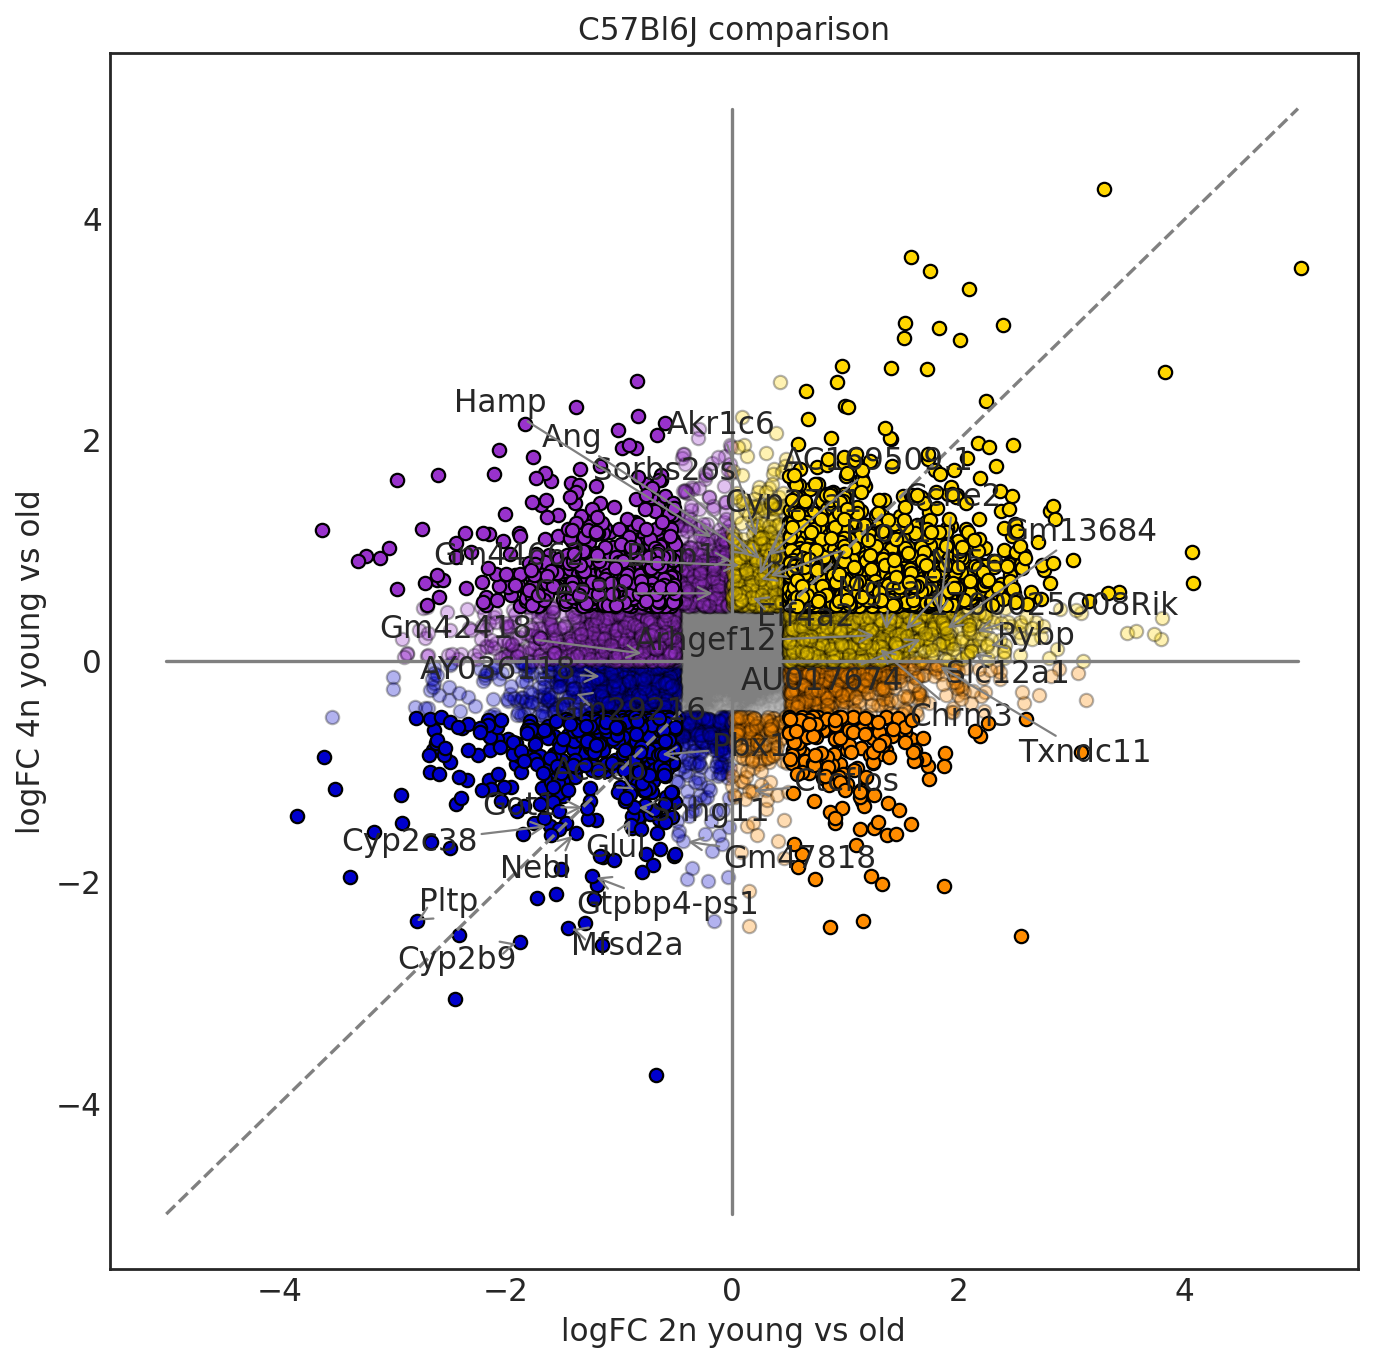

<ipython-input-52-a9045e9ecf2e>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_x['group'] = group_label_x
<ipython-input-52-a9045e9ecf2e>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_y['group'] = group_label_y


Number of significant and logFC genes per quadrant:

quadrant      0     1     2     3    All
logFC_thr                               
0           980   688  1169   881   3718
1          1339   843  1593  1328   5103
2           681   386   786   714   2567
All        3000  1917  3548  2923  11388
[array(['Cyp2c70', 'Chka', 'Prlr', 'Noct'], dtype=object), array(['Gys2', 'Mup11', 'Cyp3a11', 'Inmt', 'Gsta3', 'Cyp2d9', 'Serpina1e',
       'Selenbp2', 'Upp2', 'mt-Rnr2'], dtype=object), array(['Chka', 'Prlr', 'Cyp2c70', 'Noct'], dtype=object), array(['Serpina1e', 'Inmt', 'Mup11', 'Cyp2d9', 'Gsta3', 'mt-Rnr2',
       'Selenbp2', 'Ces1d', 'Gys2', 'Cyp3a11'], dtype=object)]


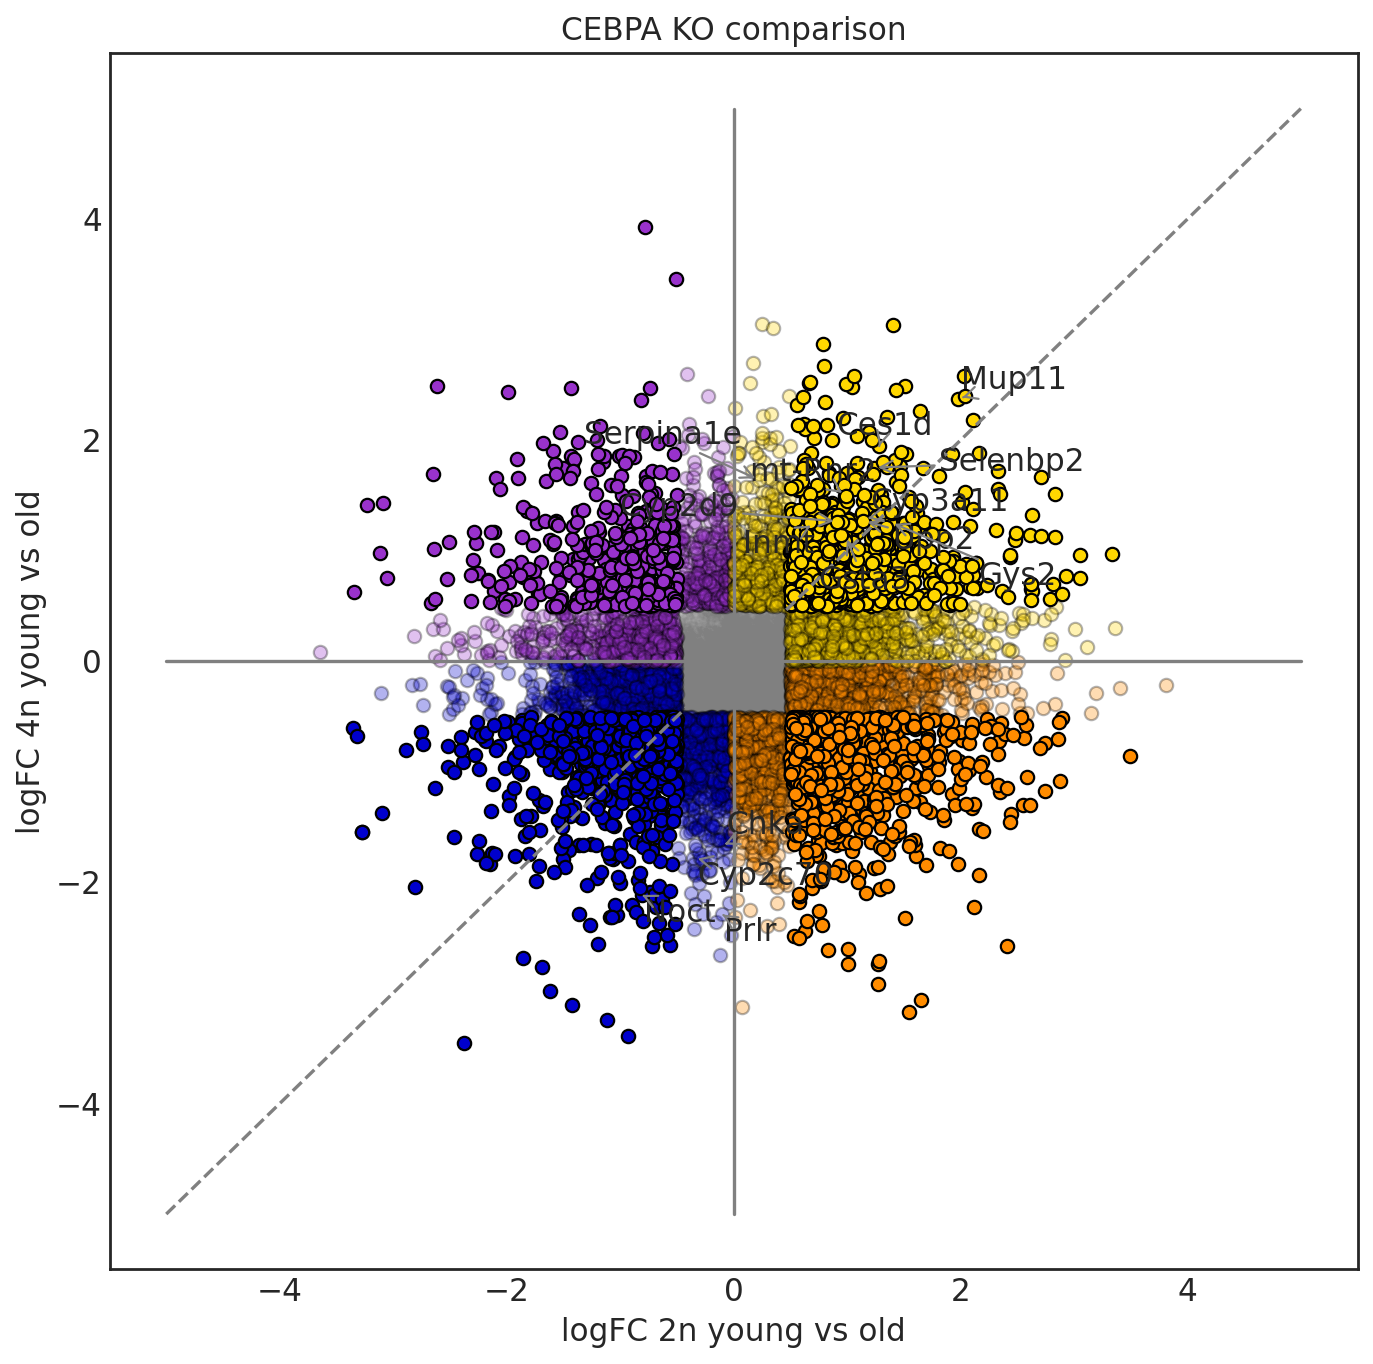

<ipython-input-52-a9045e9ecf2e>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_x['group'] = group_label_x
<ipython-input-52-a9045e9ecf2e>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_y['group'] = group_label_y


Number of significant and logFC genes per quadrant:

quadrant      0     1     2     3    All
logFC_thr                               
0          1041   642  1292   729   3704
1          1820   971  1997  1395   6183
2           948   412   749   603   2712
All        3809  2025  4038  2727  12599
[array(['Tat', 'Pck1', 'Sds', 'Mug2', 'Uox', 'Noct'], dtype=object), array(['Hsd17b6'], dtype=object), array(['Serpina1e', 'B3galt1', 'Mup14', 'Slc25a30', 'Cyp7b1', 'Mup7',
       'Serpina4-ps1', 'Selenbp2', 'Mup11'], dtype=object), array(['Mug2', 'Pck1', 'Sds', 'Tat', 'Uox', 'Noct'], dtype=object), array(['Hsd17b6'], dtype=object), array(['Mup14', 'Serpina1e', 'B3galt1', 'Slc25a30', 'Mup7', 'Mup11',
       'Serpina4-ps1', 'Cyp7b1', 'Selenbp2'], dtype=object)]


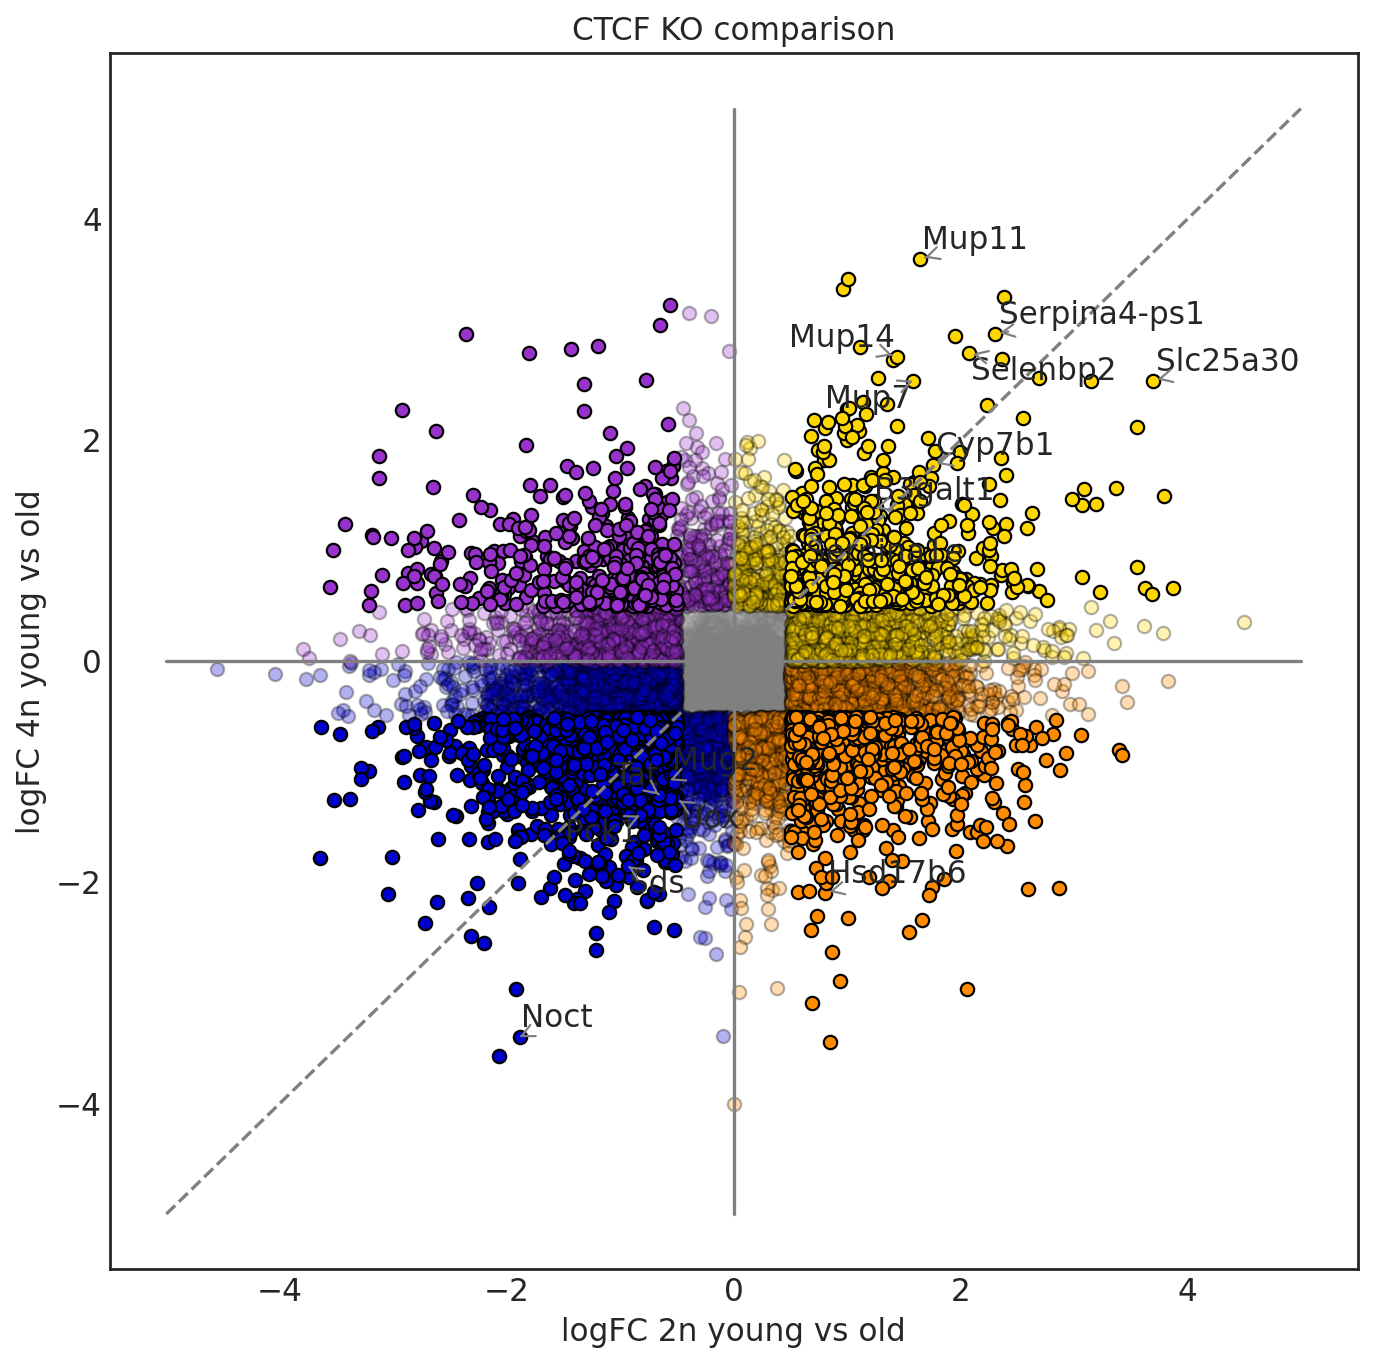

<ipython-input-52-a9045e9ecf2e>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_x['group'] = group_label_x
<ipython-input-52-a9045e9ecf2e>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_y['group'] = group_label_y


Number of significant and logFC genes per quadrant:

quadrant      0     1     2     3    All
logFC_thr                               
0           906   897   790   890   3483
1          1540  1319  1141  1449   5449
2           723   439   476   697   2335
All        3169  2655  2407  3036  11267
[array(['Scd1', 'A230050P20Rik', 'Angptl6', 'Insig1', 'Fdft1', 'Sc5d',
       'Arrdc3', 'Msmo1', 'Inmt', 'Ldlr'], dtype=object), array(['Gstp1', 'Cyp2c70'], dtype=object), array(['Acacb', 'Acss2'], dtype=object), array(['Zc3h7a', 'mt-Co1', 'Mup20', 'Amn1', 'Egfros', 'mt-Co3', 'Errfi1',
       'Tsc22d3', 'Lifr', 'Mup17'], dtype=object), array(['Arrdc3', 'Insig1', 'Msmo1', 'Fdft1', 'A230050P20Rik', 'Angptl6',
       'Cdh18', 'Inmt', 'Ldlr', 'Sc5d'], dtype=object), array(['Cyp2c70', 'Gstp1'], dtype=object), array(['Acss2', 'Acacb'], dtype=object), array(['Lifr', 'Amn1', 'mt-Co3', 'Cyp7b1', 'Zbtb20', 'Mup17', 'mt-Co1',
       'Serpina4-ps1', 'Serpina3m', 'Serpina3k'], dtype=object)]


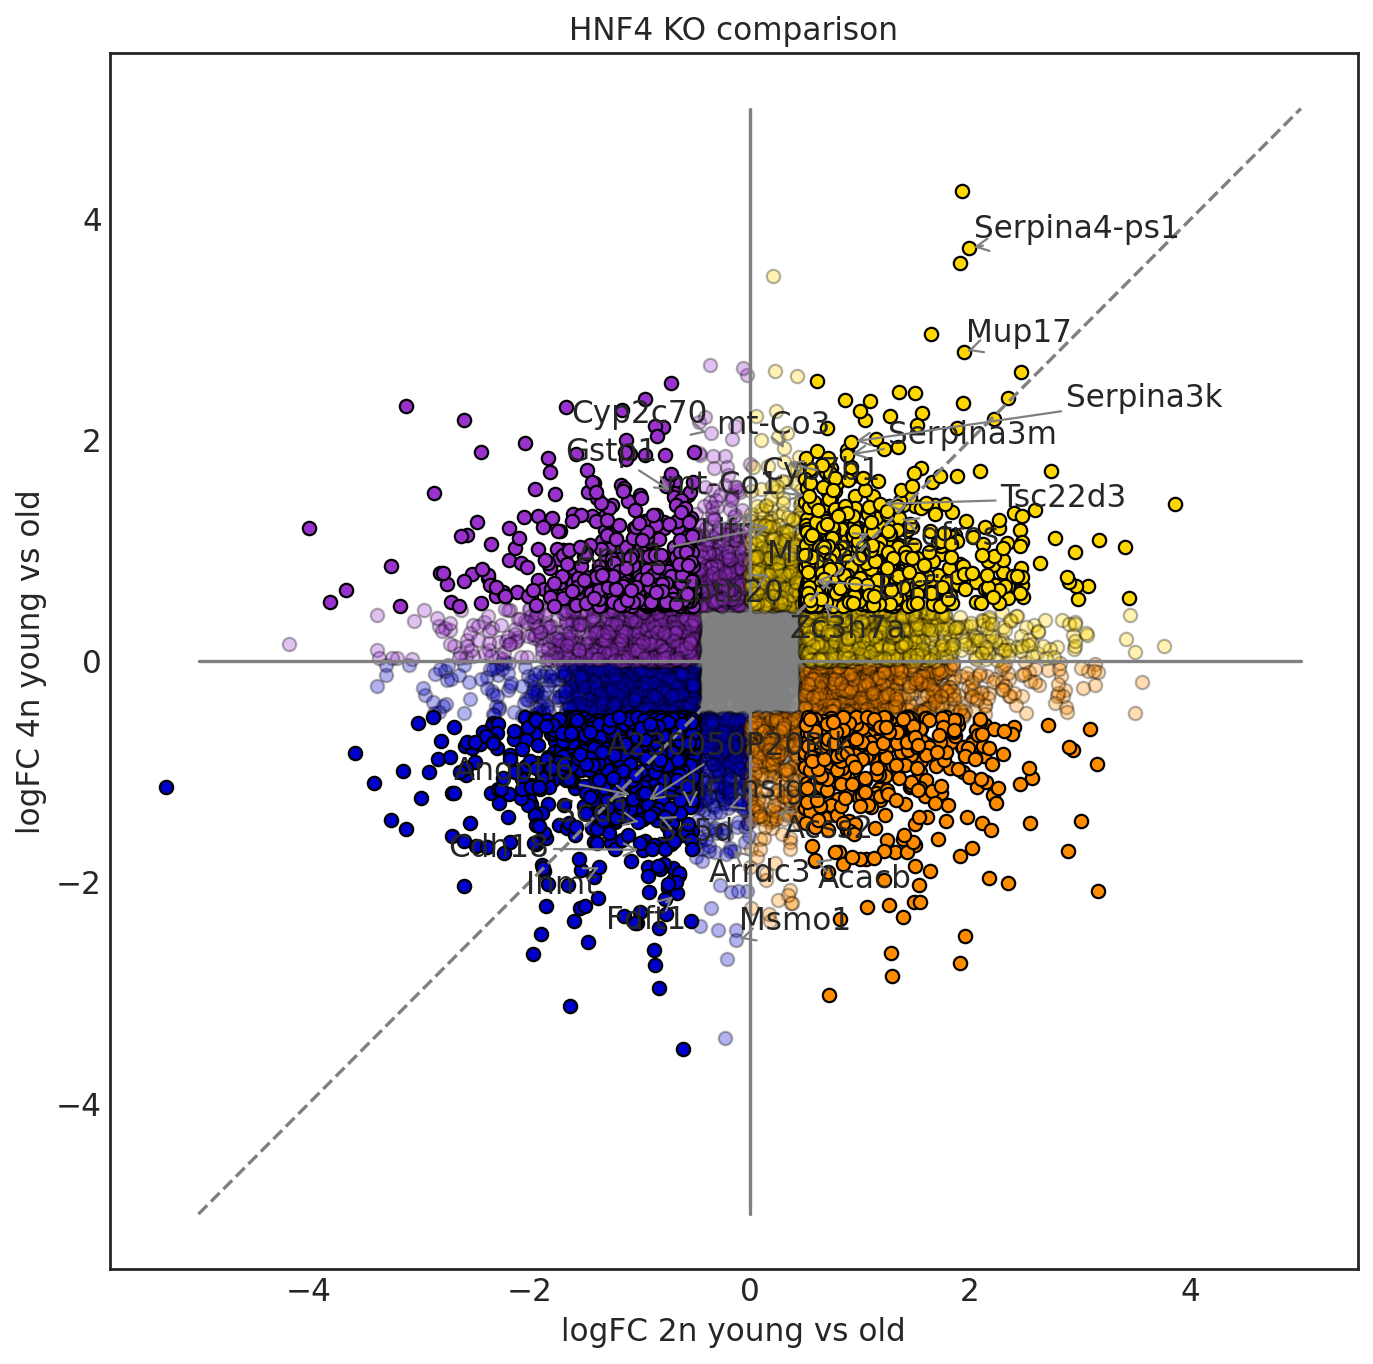

In [60]:
for strain in ['C57Bl6J', 'CEBPA KO', 'CTCF KO', 'HNF4 KO']:
    two_way_logfc_plot(data_dict = de_dict, 
                   group_x = f'young_vs_old_{strain}_2n',
                       group_label_x = '2n young vs old',
                       group_key_x = 'young_log2FC',
                       group_pval_x = 'young_pvals_adj',
                       group_y = f'young_vs_old_{strain}_4n',
                       group_label_y = '4n young vs old',
                       group_key_y = 'young_log2FC',
                       group_pval_y = 'young_pvals_adj',
                       invert_x = False,
                       invert_y = False,
                       title = strain,
                       pval_thr = 1e-5,
                       logFC_threshold = 0.5,
                       top_gene_select = None,
                       save = True)

# Create cross plots

In this section, we rotate the MA plots by 90 degrees and visualise only differentially expressed genes.

none        13956
up_young     1114
up_old         60
Name: changes_hep, dtype: int64


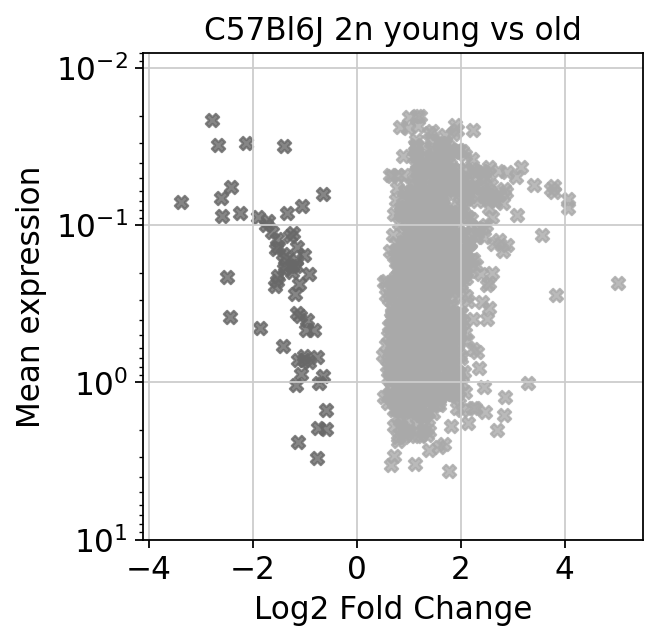

none        12452
up_young        3
Name: changes_hep, dtype: int64


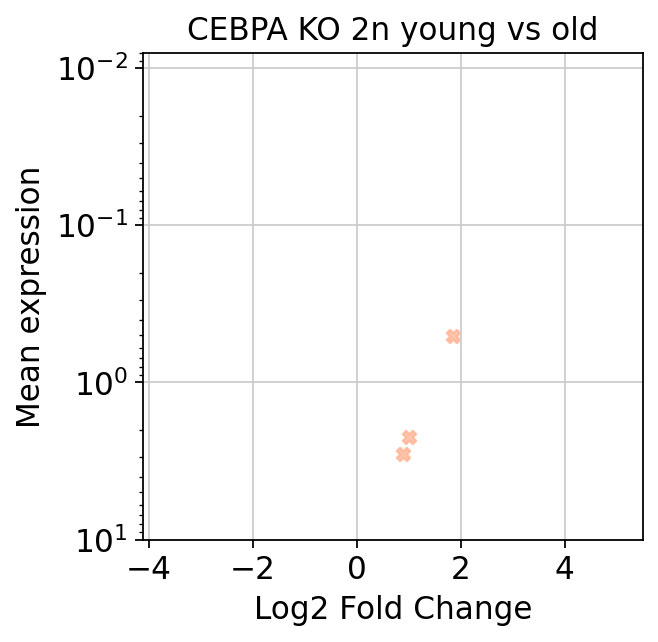

none        13232
up_young        4
up_old          1
Name: changes_hep, dtype: int64


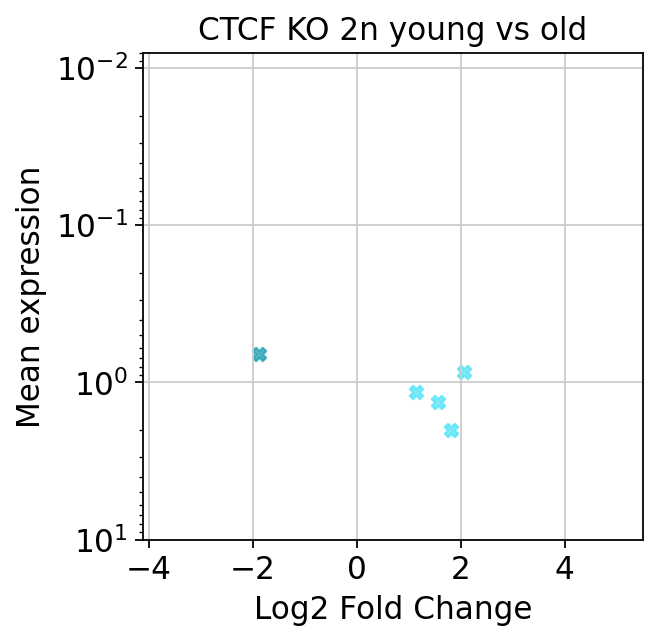

none        11659
up_young        4
Name: changes_hep, dtype: int64


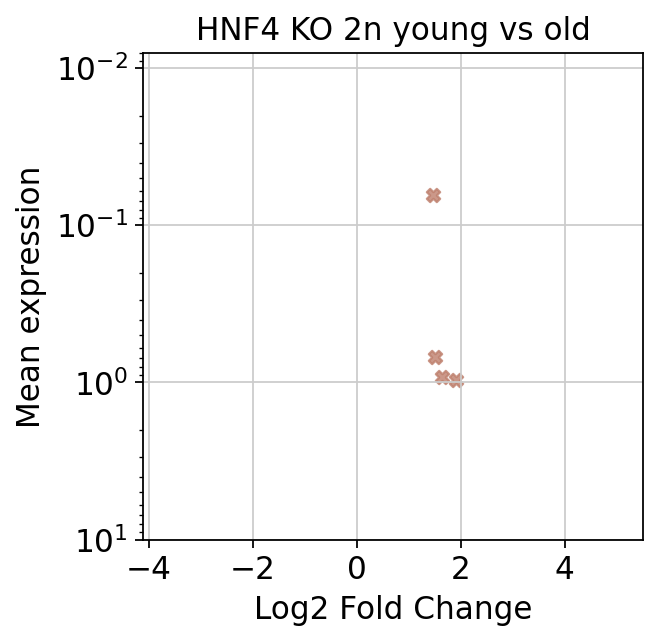

none        15090
up_young     1397
up_old        123
Name: changes_hep, dtype: int64


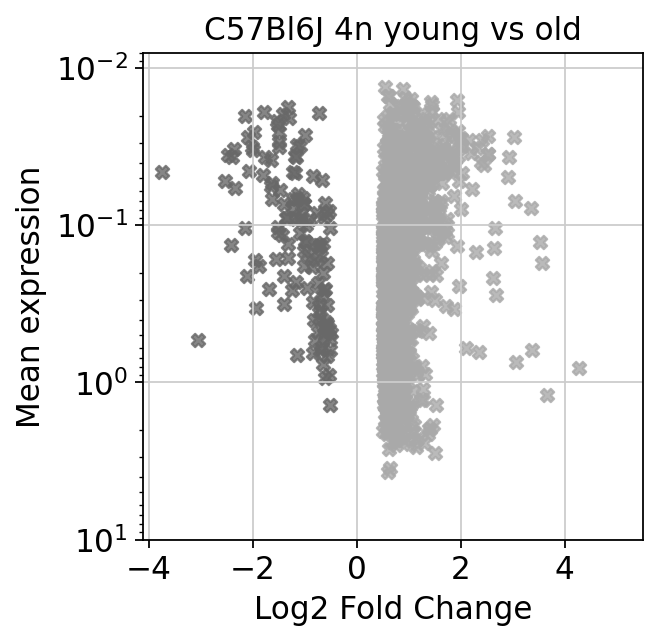

none        13447
up_old         86
up_young       77
Name: changes_hep, dtype: int64


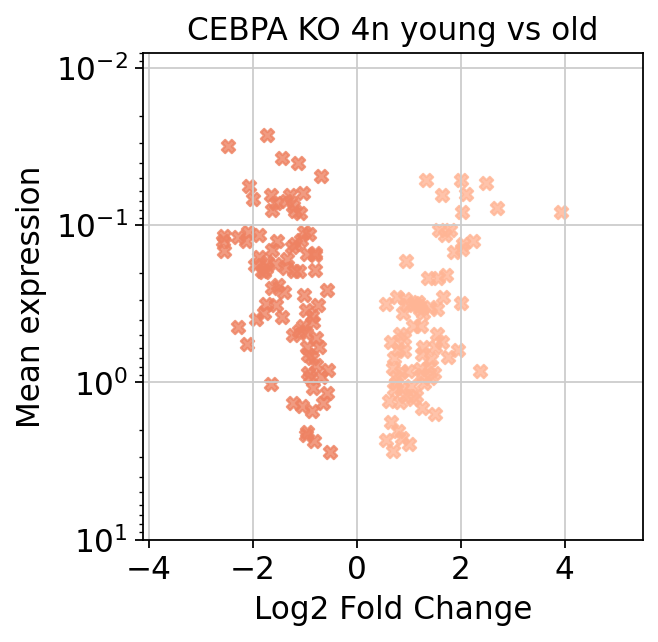

none        16064
up_old         59
up_young       24
Name: changes_hep, dtype: int64


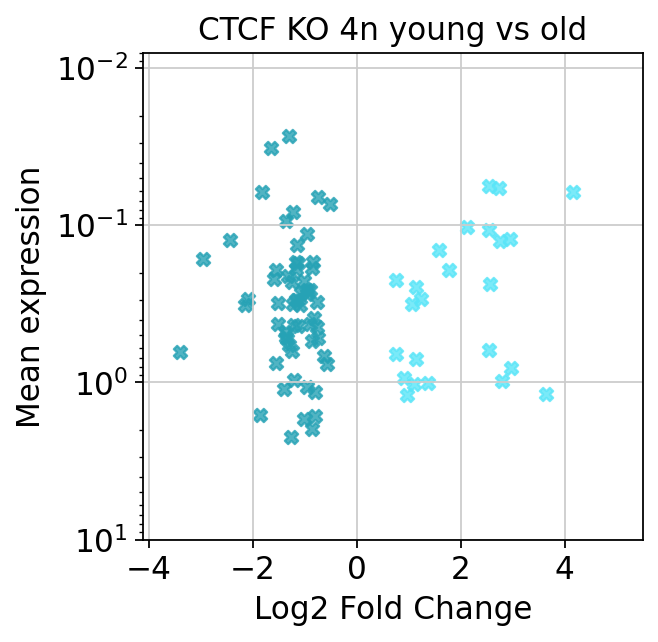

none        14772
up_young      144
up_old         86
Name: changes_hep, dtype: int64


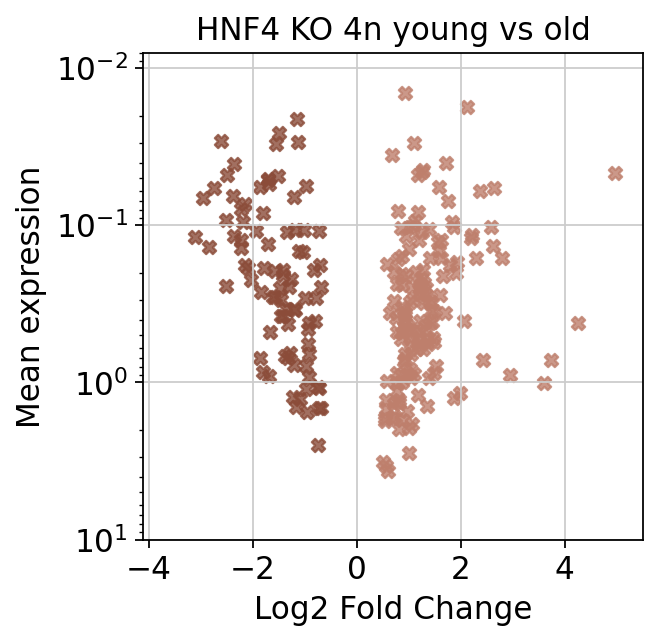

In [27]:
strain_color_dict = {
    'C57Bl6J': [ '#a9a9a9','#686868'], #[old, young]
    'HNF4 KO': [ '#BE7F6C','#8B4C39'],
    'CEBPA KO': [ '#FFB595','#EE8262'],
    'CTCF KO': [ '#59E5F8','#26a2b5']
}
for ploidy_key in ['2n', '4n']:
    for strain_key in ['C57Bl6J', 'CEBPA KO', 'CTCF KO', 'HNF4 KO']:
        data_dict = de_dict
        group_x = f'young_vs_old_{strain_key}_{ploidy_key}'
        df2 = data_dict[group_x]
        ref_name = 'old'
        test_name = 'young'
    
    #visualise differential expression results
        cols = []
        shape = []
        for elem in df2["changes_hep"]:
            if elem == "up_" +ref_name:
                cols.append(strain_color_dict[strain_key][1])
                #cols.append("#000000") #black
                #shape.append('s')
                shape.append('X')
            elif elem == "up_" + test_name:
                cols.append(strain_color_dict[strain_key][0])
                #cols.append("#000000") #black
                shape.append('X')
            else:
                cols.append("0.75")
                shape.append('.')

        print(df2['changes_hep'].value_counts())
        
    
        #create MA plot    
        alpha_val = [0.2, 0.8,0.8]
        for idx, lev in enumerate(df2['changes_hep'].unique()):
            if lev =='none':
                continue
            level = (df2['changes_hep'] == lev).values
            markers = [shap[1] for shap in enumerate(shape) if level[shap[0]]]
            color_sub = [colid[1] for colid in enumerate(cols) if level[colid[0]]]
            plt.scatter(x=df2[f"{test_name}_log2FC"][level], 
                    y=df2['mean'][level], 
                        marker= markers[0],
                        c= color_sub[0],
                        alpha=alpha_val[idx]) 
        plt.yscale("log")
        plt.ylim((10, 0.008))
        plt.xlim((-4.1,5.5))
        plt.ylabel('Mean expression')
        plt.xlabel('Log2 Fold Change')
        plt.title(strain_key + ' ' + ploidy_key + ' young vs old')
        plt.savefig("./../figures/" +today + '_' +ploidy_key + '_' + strain_key.replace('/', '') + "_cross_plot_young_vs_old_DE_filter25.pdf")
        plt.show()